In [93]:
import pandas as pd

bio = pd.read_csv(
    r"C:\Users\lokes\OneDrive\Desktop\uidai\project\data\cleaned\biometric_clean_with_source.csv",
    parse_dates=["date"],
    low_memory=False
)

bio.columns


Index(['date', 'state', 'district', 'pincode', 'bio_age_5_17',
       'bio_age_17_plus', 'source_file'],
      dtype='object')

In [94]:
bio = bio.drop(columns=["source_file"])
bio.columns


Index(['date', 'state', 'district', 'pincode', 'bio_age_5_17',
       'bio_age_17_plus'],
      dtype='object')

In [95]:
bio.to_csv(
    "../data/cleaned/biometric_final_clean.csv",
    index=False
)


# DEMOGRAPHIC CLEANING


In [99]:
import pandas as pd

demo = pd.read_csv(
    r"C:\Users\lokes\OneDrive\Desktop\uidai\demographic_clean.csv",
    parse_dates=["date"],
    low_memory=False
)

demo.columns

Index(['date', 'state', 'district', 'pincode', 'demo_age_5_17',
       'demo_age_17_plus'],
      dtype='object')

In [100]:
demo['date'] = pd.to_datetime(demo['date'], errors='coerce')
demo['demo_age_5_17'] = pd.to_numeric(demo['demo_age_5_17'], errors='coerce')
demo['demo_age_17_plus'] = pd.to_numeric(demo['demo_age_17_plus'], errors='coerce')

demo.to_csv("../data/cleaned/demographic_final_clean.csv", index=False)


# ENROLLMENT CLEANING


In [101]:
import pandas as pd

# Load raw cleaned enrollment data
enrol = pd.read_csv(
    "../data/cleaned/enrollment_clean.csv",
    parse_dates=["date"],
    low_memory=False
)

# Inspect schema (sanity check)
enrol.columns


Index(['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17',
       'age_18_greater'],
      dtype='object')

In [104]:
# Enforce numeric types (safe coercion)
enrol['age_0_5'] = pd.to_numeric(enrol['age_0_5'], errors='coerce')
enrol['age_5_17'] = pd.to_numeric(enrol['age_5_17'], errors='coerce')
enrol['age_18_greater'] = pd.to_numeric(enrol['age_18_greater'], errors='coerce')

# Quick sanity check
enrol.head()

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,2025-03-02,Meghalaya,East Khasi Hills,793121,11,61,37
1,2025-03-09,Karnataka,Bengaluru Urban,560043,14,33,39
2,2025-03-09,Uttar Pradesh,Kanpur Nagar,208001,29,82,12
3,2025-03-09,Uttar Pradesh,Aligarh,202133,62,29,15
4,2025-03-09,Karnataka,Bengaluru Urban,560016,14,16,21


In [105]:
# Save final cleaned enrollment file (ONE TIME ONLY)
enrol.to_csv(
    "../data/cleaned/enrollment_final_clean.csv",
    index=False
)

# =====================================
# ANALYSIS: Aadhaar Lifecycle Pressure
# =====================================
All analysis below uses final cleaned datasets only.
No further data preparation is performed.


In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore


In [107]:
bio = pd.read_csv("../data/cleaned/biometric_final_clean.csv", parse_dates=["date"])
demo = pd.read_csv("../data/cleaned/demographic_final_clean.csv", parse_dates=["date"])
enrol = pd.read_csv("../data/cleaned/enrollment_final_clean.csv", parse_dates=["date"])


In [108]:
# =====================================
# STATE CLEANING UTILITIES (ANALYSIS)
# =====================================

STATE_FIX_MAP = {
    "Chhatisgarh": "Chhattisgarh",
    "Uttaranchal": "Uttarakhand",
    "West Bangal": "West Bengal",
    "Westbengal": "West Bengal",
    "Orissa": "Odisha",
    "Pondicherry": "Puducherry",
    "Dadra And Nagar Haveli": "Dadra And Nagar Haveli And Daman And Diu",
    "Daman And Diu": "Dadra And Nagar Haveli And Daman And Diu",
    "The Dadra And Nagar Haveli And Daman And Diu": "Dadra And Nagar Haveli And Daman And Diu",
    "Andaman & Nicobar Islands": "Andaman And Nicobar Islands",
}

def standardize_state_names(df):
    df = df.copy()
    df['state'] = (
        df['state']
        .astype(str)
        .str.replace('&', 'and', regex=False)
        .str.replace(r'\s+', ' ', regex=True)
        .str.strip()
        .str.title()
    )
    return df

def apply_state_fix(df):
    df = df.copy()
    df['state'] = df['state'].replace(STATE_FIX_MAP)
    return df

def remove_invalid_states(df):
    df = df.copy()
    df['state'] = df['state'].astype(str)
    df = df[~df['state'].str.match(r'^\d+$')]
    return df


In [109]:
for name in ['bio', 'demo', 'enrol']:
    df = locals()[name]
    df = standardize_state_names(df)
    df = apply_state_fix(df)
    df = remove_invalid_states(df)
    locals()[name] = df


In [111]:
# =====================================
# CREATE MONTH COLUMN (FOR TIME ANALYSIS)
# =====================================

enrol = enrol.copy()
enrol['month'] = enrol['date'].dt.to_period("M")


In [114]:
enrol[['date','month']].head()


,date,month
0,2025-03-02,2025-03
1,2025-03-09,2025-03
2,2025-03-09,2025-03
3,2025-03-09,2025-03
4,2025-03-09,2025-03


STEP 3: Aggregate ENROLLMENT (State + Month)


In [113]:
enrol_sm = (
    enrol
    .groupby(['month', 'state'], as_index=False)
    [['age_0_5', 'age_5_17', 'age_18_greater']]
    .sum()
)

enrol_sm['enrolments'] = (
    enrol_sm['age_0_5']
    + enrol_sm['age_5_17']
    + enrol_sm['age_18_greater']
)

enrol_sm.head()

,month,state,age_0_5,age_5_17,age_18_greater,enrolments
0,2025-03,Andhra Pradesh,43,44,29,116
1,2025-03,Assam,587,1105,800,2492
2,2025-03,Bihar,516,1392,444,2352
3,2025-03,Chhattisgarh,115,46,99,260
4,2025-03,Delhi,181,102,85,368


# STEP 4: Aggregate DEMOGRAPHIC UPDATES

In [115]:
# =====================================
# CREATE MONTH COLUMN (DEMOGRAPHIC)
# =====================================

demo = demo.copy()
demo['month'] = demo['date'].dt.to_period("M")


In [116]:
# =====================================
# AGGREGATION: DEMOGRAPHIC UPDATES (State + Month)
# =====================================

demo_sm = (
    demo
    .groupby(['month', 'state'], as_index=False)
    [['demo_age_5_17', 'demo_age_17_plus']]
    .sum()
)

demo_sm['demo_updates'] = (
    demo_sm['demo_age_5_17']
    + demo_sm['demo_age_17_plus']
)

demo_sm.head()


,month,state,demo_age_5_17,demo_age_17_plus,demo_updates
0,2025-03,Andaman And Nicobar Islands,126,1212,1338
1,2025-03,Andhra Pradesh,48600,464440,513040
2,2025-03,Arunachal Pradesh,852,6957,7809
3,2025-03,Assam,16692,185345,202037
4,2025-03,Bihar,95221,991478,1086699


# STEP 5: Aggregate BIOMETRIC UPDATES

In [117]:
# =====================================
# CREATE MONTH COLUMN (BIOMETRIC)
# =====================================

bio = bio.copy()
bio['month'] = bio['date'].dt.to_period("M")


In [118]:
# =====================================
# AGGREGATION: BIOMETRIC UPDATES (State + Month)
# =====================================

bio_sm = (
    bio
    .groupby(['month', 'state'], as_index=False)
    [['bio_age_5_17', 'bio_age_17_plus']]
    .sum()
)

bio_sm['bio_updates'] = (
    bio_sm['bio_age_5_17']
    + bio_sm['bio_age_17_plus']
)

bio_sm.head()


,month,state,bio_age_5_17,bio_age_17_plus,bio_updates
0,2025-01,Andaman And Nicobar Islands,6467,6083,12550
1,2025-01,Andhra Pradesh,1540426,875186,2415612
2,2025-01,Arunachal Pradesh,19513,21007,40520
3,2025-01,Assam,319234,180583,499817
4,2025-01,Bihar,1547373,1726934,3274307


In [119]:
# =====================================
# VERIFY UNIQUENESS BEFORE MERGE
# =====================================

print(
    enrol_sm.duplicated(['month', 'state']).sum(),
    demo_sm.duplicated(['month', 'state']).sum(),
    bio_sm.duplicated(['month', 'state']).sum()
)


0 0 0


In [120]:
# =====================================
# FINAL MERGE: ENROL + DEMO + BIO
# =====================================

merged = (
    enrol_sm[['month', 'state', 'enrolments']]
    .merge(
        demo_sm[['month', 'state', 'demo_updates']],
        on=['month', 'state'],
        how='left'
    )
    .merge(
        bio_sm[['month', 'state', 'bio_updates']],
        on=['month', 'state'],
        how='left'
    )
)

merged = merged.fillna(0)
merged.head()


,month,state,enrolments,demo_updates,bio_updates
0,2025-03,Andhra Pradesh,116,513040.0,50392
1,2025-03,Assam,2492,202037.0,18107
2,2025-03,Bihar,2352,1086699.0,79328
3,2025-03,Chhattisgarh,260,301466.0,55140
4,2025-03,Delhi,368,266319.0,15506


In [121]:
# =====================================
# LIFECYCLE PRESSURE INDEX (CORE METRIC)
# =====================================

merged['lpi'] = (
    merged['demo_updates'] + merged['bio_updates']
) / merged['enrolments']

merged.head()


,month,state,enrolments,demo_updates,bio_updates,lpi
0,2025-03,Andhra Pradesh,116,513040.0,50392,4857.172414
1,2025-03,Assam,2492,202037.0,18107,88.340289
2,2025-03,Bihar,2352,1086699.0,79328,495.759779
3,2025-03,Chhattisgarh,260,301466.0,55140,1371.561538
4,2025-03,Delhi,368,266319.0,15506,765.828804


In [122]:
merged[['state', 'lpi']].sort_values('lpi', ascending=False).head(5)


,state,lpi
14,Tamil Nadu,17402.147059
13,Rajasthan,13210.308511
7,Jharkhand,10610.454545
17,West Bengal,4977.123967
0,Andhra Pradesh,4857.172414


# NEXT STEP: RANK HIGH-PRESSURE STATES (FINAL TABLE)

In [123]:
# =====================================
# STATE-LEVEL LIFECYCLE PRESSURE (RANKING)
# =====================================

state_lpi = (
    merged
    .groupby('state')['lpi']
    .mean()
    .sort_values(ascending=False)
)

state_lpi.head(10)


state
Tamil Nadu        2003.803373
Rajasthan         1479.322559
Jharkhand         1332.132785
Andhra Pradesh     735.111979
West Bengal        563.746357
Maharashtra        224.936560
Chhattisgarh       213.974186
Madhya Pradesh     163.884975
Haryana            138.994717
Punjab             135.188073
Name: lpi, dtype: float64

# NEXT STEP: FIRST PDF-READY CHART (MANDATORY)

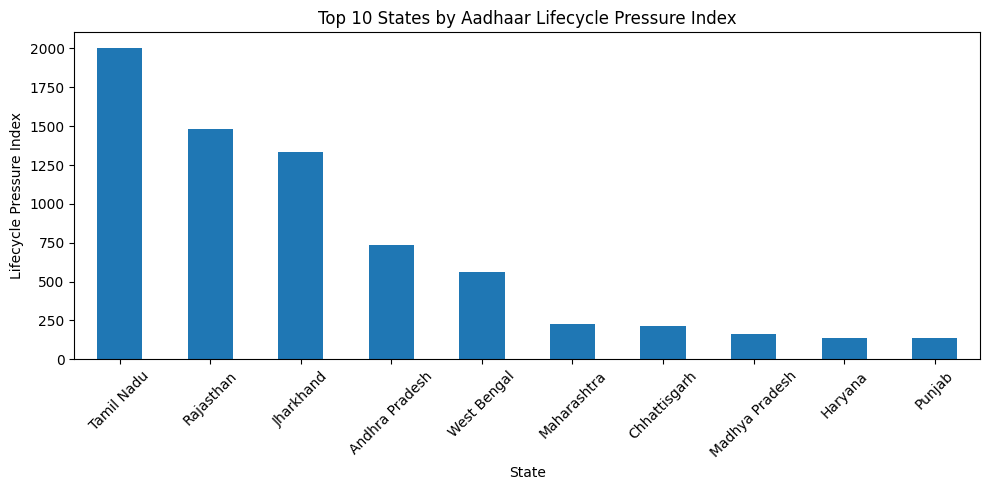

In [124]:
# =====================================
# TOP 10 STATES BY LIFECYCLE PRESSURE
# =====================================

import matplotlib.pyplot as plt

state_lpi.head(10).plot(
    kind='bar',
    figsize=(10,5),
    title='Top 10 States by Aadhaar Lifecycle Pressure Index'
)

plt.ylabel('Lifecycle Pressure Index')
plt.xlabel('State')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# NEXT STEP: CHILD vs ADULT PRESSURE (THIS IS YOUR EDGE)

This answers a policy-level question:

“Is pressure coming from children (education, biometric lifecycle) or adults (migration, workforce churn)?”

UIDAI and ministries care deeply about this distinction.

In [125]:
# =====================================
# PREPARE MONTH COLUMN
# =====================================

enrol = enrol.copy()
enrol['month'] = enrol['date'].dt.to_period("M")

demo = demo.copy()
demo['month'] = demo['date'].dt.to_period("M")

bio = bio.copy()
bio['month'] = bio['date'].dt.to_period("M")


In [126]:
# =====================================
# AGE-WISE ENROLMENT AGGREGATION
# =====================================

enrol_age_sm = (
    enrol
    .groupby(['month', 'state'], as_index=False)
    [['age_0_5', 'age_5_17', 'age_18_greater']]
    .sum()
)

enrol_age_sm.head()


,month,state,age_0_5,age_5_17,age_18_greater
0,2025-03,Andhra Pradesh,43,44,29
1,2025-03,Assam,587,1105,800
2,2025-03,Bihar,516,1392,444
3,2025-03,Chhattisgarh,115,46,99
4,2025-03,Delhi,181,102,85


In [127]:
# =====================================
# CHILD vs ADULT ENROLMENTS
# =====================================

enrol_age_sm['child_enrolments'] = (
    enrol_age_sm['age_0_5'] + enrol_age_sm['age_5_17']
)

enrol_age_sm['adult_enrolments'] = enrol_age_sm['age_18_greater']

enrol_age_sm[['state', 'child_enrolments', 'adult_enrolments']].head()


,state,child_enrolments,adult_enrolments
0,Andhra Pradesh,87,29
1,Assam,1692,800
2,Bihar,1908,444
3,Chhattisgarh,161,99
4,Delhi,283,85


In [128]:
# =====================================
# AGE-WISE DEMOGRAPHIC UPDATES
# =====================================

demo_age_sm = (
    demo
    .groupby(['month', 'state'], as_index=False)
    [['demo_age_5_17', 'demo_age_17_plus']]
    .sum()
)

demo_age_sm.head()


,month,state,demo_age_5_17,demo_age_17_plus
0,2025-03,Andaman And Nicobar Islands,126,1212
1,2025-03,Andhra Pradesh,48600,464440
2,2025-03,Arunachal Pradesh,852,6957
3,2025-03,Assam,16692,185345
4,2025-03,Bihar,95221,991478


In [129]:
# =====================================
# AGE-WISE BIOMETRIC UPDATES
# =====================================

bio_age_sm = (
    bio
    .groupby(['month', 'state'], as_index=False)
    [['bio_age_5_17', 'bio_age_17_plus']]
    .sum()
)

bio_age_sm.head()


,month,state,bio_age_5_17,bio_age_17_plus
0,2025-01,Andaman And Nicobar Islands,6467,6083
1,2025-01,Andhra Pradesh,1540426,875186
2,2025-01,Arunachal Pradesh,19513,21007
3,2025-01,Assam,319234,180583
4,2025-01,Bihar,1547373,1726934


In [130]:
# =====================================
# MERGE AGE-WISE ENROLMENTS + UPDATES
# =====================================

age_pressure = (
    enrol_age_sm
    .merge(demo_age_sm, on=['month', 'state'], how='left')
    .merge(bio_age_sm, on=['month', 'state'], how='left')
    .fillna(0)
)

age_pressure.head()


,month,state,age_0_5,age_5_17,age_18_greater,child_enrolments,adult_enrolments,demo_age_5_17,demo_age_17_plus,bio_age_5_17,bio_age_17_plus
0,2025-03,Andhra Pradesh,43,44,29,87,29,48600.0,464440.0,23606,26786
1,2025-03,Assam,587,1105,800,1692,800,16692.0,185345.0,11397,6710
2,2025-03,Bihar,516,1392,444,1908,444,95221.0,991478.0,30292,49036
3,2025-03,Chhattisgarh,115,46,99,161,99,18699.0,282767.0,25566,29574
4,2025-03,Delhi,181,102,85,283,85,24234.0,242085.0,6902,8604


# NEXT STEP: COMPUTE CHILD vs ADULT PRESSURE (THIS IS THE PAYOFF)

In [131]:
# =====================================
# CHILD vs ADULT PRESSURE (CORE INSIGHT)
# =====================================

# Child-driven pressure (0–17 years)
age_pressure['child_pressure'] = (
    (age_pressure['demo_age_5_17'] + age_pressure['bio_age_5_17']) /
    (age_pressure['age_0_5'] + age_pressure['age_5_17']).replace(0, 1)
)

# Adult-driven pressure (18+ years)
age_pressure['adult_pressure'] = (
    (age_pressure['demo_age_17_plus'] + age_pressure['bio_age_17_plus']) /
    age_pressure['age_18_greater'].replace(0, 1)
)

age_pressure[['state', 'child_pressure', 'adult_pressure']].head()


,state,child_pressure,adult_pressure
0,Andhra Pradesh,829.954023,16938.827586
1,Assam,16.601064,240.068750
2,Bihar,65.782495,2343.500000
3,Chhattisgarh,274.937888,3154.959596
4,Delhi,110.021201,2949.282353


In [132]:
# =====================================
# STATES WITH HIGHEST CHILD-DRIVEN PRESSURE
# =====================================

child_pressure_state = (
    age_pressure
    .groupby('state')['child_pressure']
    .mean()
    .sort_values(ascending=False)
)

child_pressure_state.head(10)


state
Tamil Nadu        432.815136
Rajasthan         160.463950
Andhra Pradesh    130.064003
Jharkhand         113.778716
West Bengal        78.460920
Chhattisgarh       41.270682
Maharashtra        34.745171
Madhya Pradesh     31.463454
Karnataka          24.991200
Haryana            24.491165
Name: child_pressure, dtype: float64

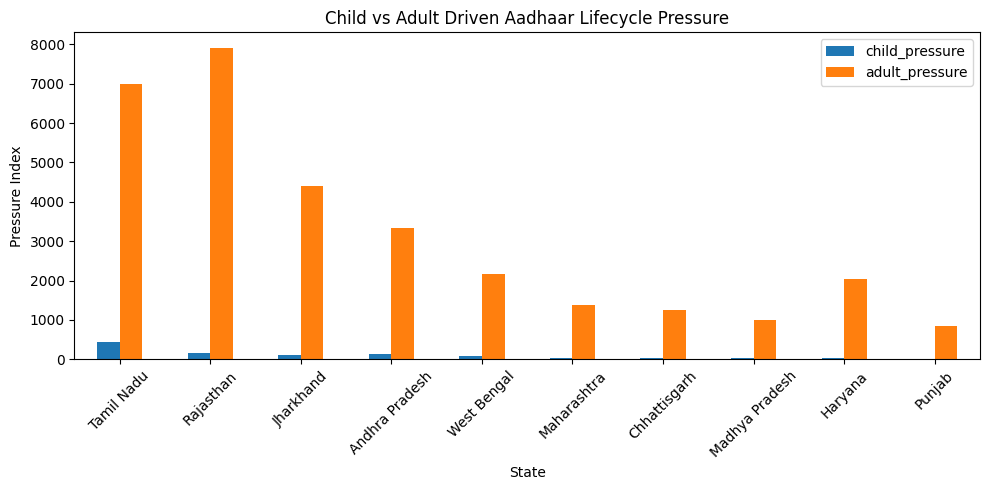

In [ ]:
# =====================================
# CHILD vs ADULT PRESSURE COMPARISON
# =====================================

top_states = state_lpi.head(10).index

age_compare = (
    age_pressure
    .groupby('state')[['child_pressure', 'adult_pressure']]
    .mean()
    .loc[top_states]
)

age_compare.plot(
    kind='bar',
    figsize=(10,5),
    title='Child vs Adult Driven Aadhaar Lifecycle Pressure'
)

plt.ylabel('Pressure Index')
plt.xlabel('State')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# TIME-TREND ANALYSIS (TRIVARIATE → REQUIRED)

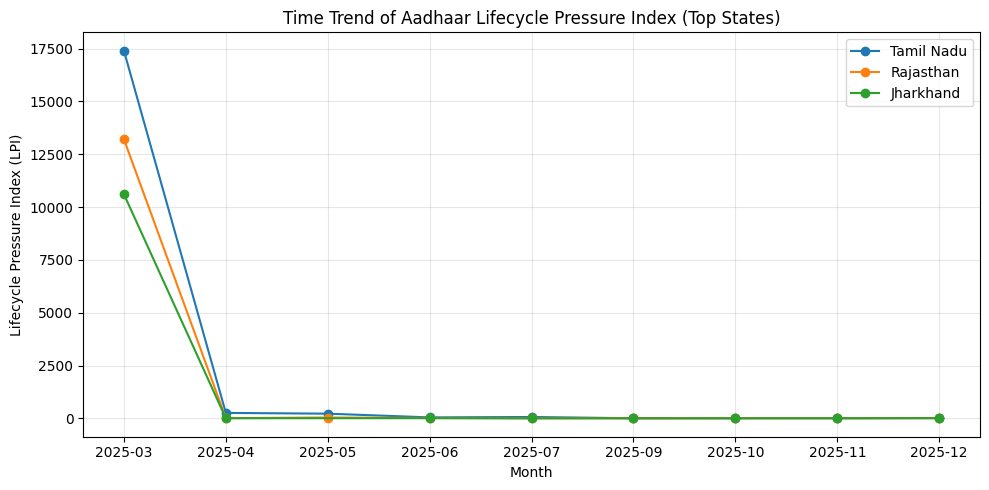

In [134]:
# =====================================
# TIME TREND OF LIFECYCLE PRESSURE (TOP STATES)
# =====================================

merged = merged.copy()
merged['month'] = merged['month'].astype(str)

top_states = state_lpi.head(3).index.tolist()

plt.figure(figsize=(10,5))

for state in top_states:
    temp = merged[merged['state'] == state].sort_values('month')
    plt.plot(temp['month'], temp['lpi'], marker='o', label=state)

plt.title('Time Trend of Aadhaar Lifecycle Pressure Index (Top States)')
plt.xlabel('Month')
plt.ylabel('Lifecycle Pressure Index (LPI)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Z-SCORE ANOMALY DETECTION (STATISTICAL RIGOUR)

In [140]:
# =====================================
# STATISTICAL ANOMALY DETECTION (Z-SCORE)
# =====================================

from scipy.stats import zscore

state_lpi_df = (
    merged
    .groupby('state', as_index=False)['lpi']
    .mean()
)

state_lpi_df['lpi_zscore'] = zscore(state_lpi_df['lpi'])

anomalous_states = (
    state_lpi_df
    .query('abs(lpi_zscore) > 3')
    .sort_values('lpi_zscore', ascending=False)
)

anomalous_states


,state,lpi,lpi_zscore
30,Tamil Nadu,2003.803373,3.954182


In [141]:
# =====================================
# FINAL STATE NAME SANITY CHECK
# =====================================

sorted(merged['state'].unique())


['Andaman And Nicobar Islands',
 'Andhra Pradesh',
 'Arunachal Pradesh',
 'Assam',
 'Bihar',
 'Chandigarh',
 'Chhattisgarh',
 'Dadra And Nagar Haveli And Daman And Diu',
 'Delhi',
 'Goa',
 'Gujarat',
 'Haryana',
 'Himachal Pradesh',
 'Jammu And Kashmir',
 'Jharkhand',
 'Karnataka',
 'Kerala',
 'Ladakh',
 'Lakshadweep',
 'Madhya Pradesh',
 'Maharashtra',
 'Manipur',
 'Meghalaya',
 'Mizoram',
 'Nagaland',
 'Odisha',
 'Puducherry',
 'Punjab',
 'Rajasthan',
 'Sikkim',
 'Tamil Nadu',
 'Telangana',
 'Tripura',
 'Uttar Pradesh',
 'Uttarakhand',
 'West Bengal']


### Final Data Integrity Check
<Mark>
This cell verifies that all state and union territory identifiers are canonical and free of duplication after the complete analysis pipeline.
</Mark>